# Classification Notebook: Adult Income Dataset

# 1. Imports

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 2. Load the Dataset

In [ ]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
df = pd.read_csv("data/adult.data", header=None, names=column_names, na_values=" ?", skipinitialspace=True)


# 3. Prétraitement des Données
3.1. Nettoyage des données

In [3]:
# check for missing values 
print("Missing values per column:\n", df.isnull().sum())
# delete rows with missing values
df.dropna(inplace=True)

Missing values per column:
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [4]:
#check for duplicates
print("Duplicates in the dataset: ", df.duplicated().sum())
# delete duplicates
df.drop_duplicates(inplace=True)

Duplicates in the dataset:  24


3.2. Exploration des donnees:
- Analyse statistique (moyenne, mediane, ́ecart-type, etc.).

In [5]:
# Analyse statistique (moyenne, m ́ediane,  ́ecart-type, etc.)
print("Statistical analysis of the dataset:\n", df.describe())

Statistical analysis of the dataset:
                 age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32537.000000  3.253700e+04   32537.000000  32537.000000  32537.000000   
mean      38.585549  1.897808e+05      10.081815   1078.443741     87.368227   
std       13.637984  1.055565e+05       2.571633   7387.957424    403.101833   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.369930e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32537.000000  
mean        40.440329  
std         12.346889  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


- Visualisation des donnees (histogrammes, boxplots, heatmaps de correlation).

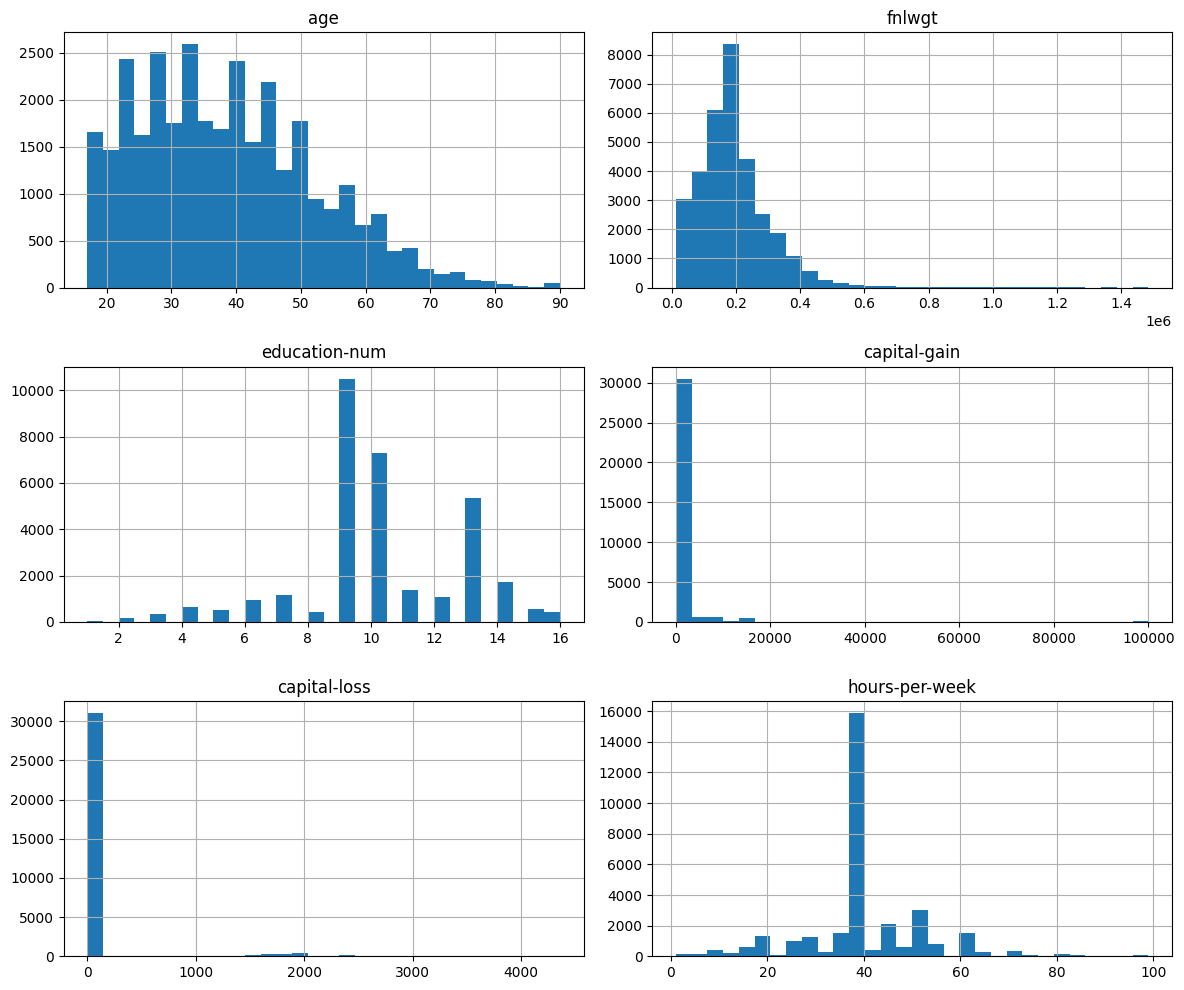

In [6]:
# Visualisation des donnees (histogrammes, boxplots, heatmaps de correlation).
# Histogrammes
df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

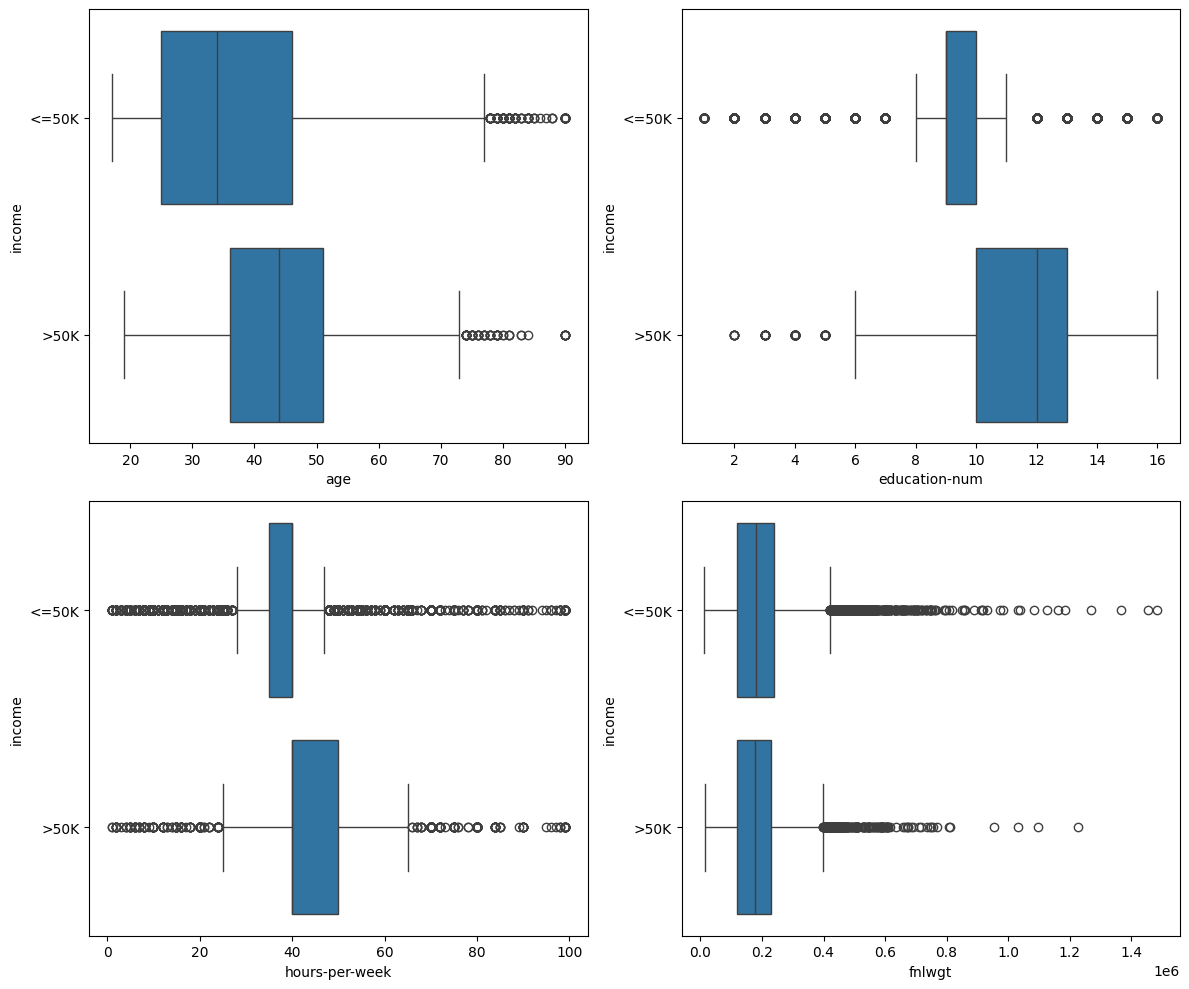

In [7]:
# Boxplots of some features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(x='age', y='income', data=df, ax=axes[0, 0])
sns.boxplot(x='education-num', y='income', data=df, ax=axes[0, 1])
sns.boxplot(x='hours-per-week', y='income', data=df, ax=axes[1, 0])
sns.boxplot(x='fnlwgt', y='income', data=df, ax=axes[1, 1])
plt.tight_layout()
plt.show()

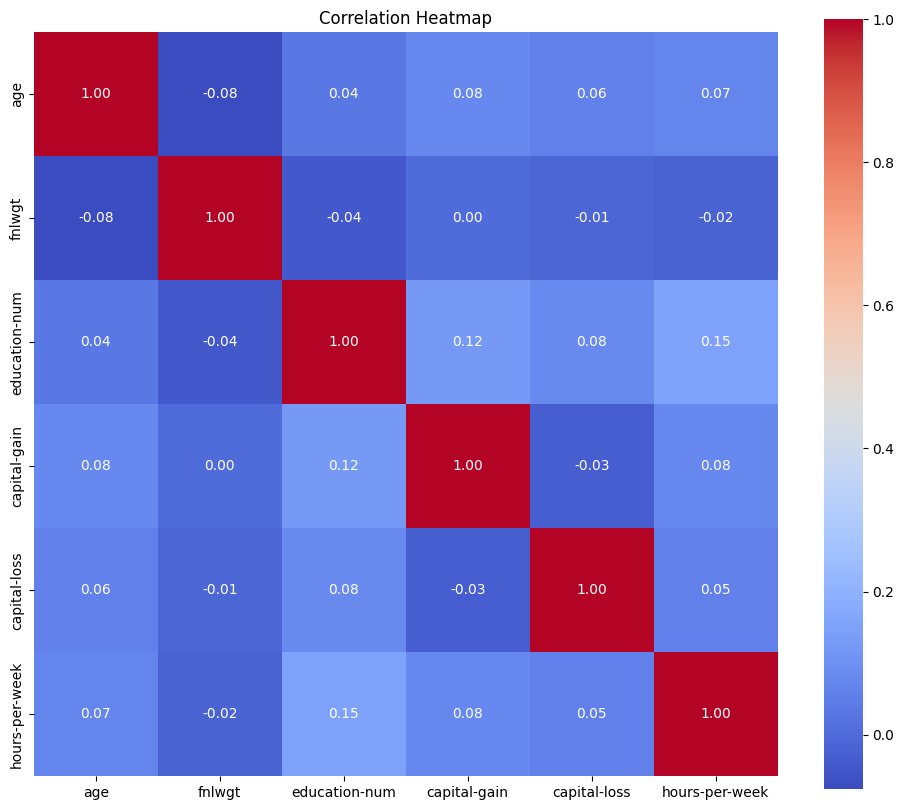

In [8]:
# Heatmap de correlation (seulement pour les colonnes numériques)
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

# 4. Transformation des donnees :
- Encodage des variables categorielles (One-Hot Encoding, Label En-
coding).
- Normalisation ou standardisation des donnees.

In [9]:
# Label Encoding for categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].str.strip()  # Remove leading/trailing whitespace
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Normalisation des donnees
scaler = StandardScaler()   # formula: z = (x - mean) / std
df[df.columns] = scaler.fit_transform(df[df.columns])
# Split the data into features and target variable
X = df.drop("income", axis=1)
y = df["income"]

# 5. Separation des donn ́ees :
- Diviser les donnees en ensembles d’entrainement et de test (e.g., 80/20
ou 70/30)

In [10]:
# Split the data into training and testing sets 
# (percentage of 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Modelisation 


- modelisation des metriques

In [11]:
# defining the metrics scores from scratch withot using sklearn 
# confusion matrix
def confusion_matrix(y_true, y_pred):
    # returns the TN, FP, FN, TP
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TP = np.sum((y_true == 1) & (y_pred == 1))

    cm = np.array([[TN, FP], [FN, TP]])
    return cm, TN, FP, FN, TP

# accuracy
def accuracyScratch(TP, TN, FP, FN):
    # returns the accuracy score
    return (TP + TN) / (TP + TN + FP + FN)
# precision
def precisionScratch(TP, FP):
    # returns the precision score
    return TP / (TP + FP) if (TP + FP) != 0 else 0
# recall
def recallScratch(TP, FN):
    return TP / (TP + FN) if (TP + FN) != 0 else 0
# f1 score
def f1_scoreScratch(TP, FP, FN):
    precision = precisionScratch(TP, FP)
    recall = recallScratch(TP, FN)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
# # ROC curve
# def roc_curve(y_true, y_scores):
#     thresholds = np.arange(0, 1.01, 0.01)
#     tpr = []
#     fpr = []
#     for threshold in thresholds:
#         y_pred = (y_scores >= threshold).astype(int)
#         cm, TN, FP, FN, TP = confusion_matrix(y_true, y_pred)
#         tpr.append(recallScratch(TP, FN))
#         fpr.append(precisionScratch(TP, FP))
#     return fpr, tpr

# AUC
# def auc(fpr, tpr):
#     return np.trapezoid(tpr, fpr)

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm, TN, FP, FN, TP = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [12]:
#cross validation function from scratch
def cross_val_score_manual(model, X, y, cv=5):
    n = len(y)
    fold_size = n // cv
    scores = []
    for i in range(cv):
        X_train = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
        y_train = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])
        model.fit(X_train, y_train)
        scores.append(model.score(X, y))
    return np.array(scores)

- modelisation des models

In [13]:
# modelisation
# Régression logistique from scratch (numpy)
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.theta = np.zeros(X.shape[1])
        self.bias = 0
        for _ in range(self.n_iter):
            linear = np.dot(X, self.theta) + self.bias
            y_pred = self.sigmoid(linear)
            error = y_pred - y
            grad_theta = np.dot(X.T, error) / len(y)
            grad_bias = np.mean(error)
            self.theta -= self.lr * grad_theta
            self.bias -= self.lr * grad_bias

    def predict_proba(self, X):
        linear = np.dot(X, self.theta) + self.bias
        return self.sigmoid(linear)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    
    # def _entropy(self, y):
    #     class_labels, counts = np.unique(y, return_counts=True)
    #     probabilities = counts / len(y)
    #     return -np.sum(probabilities * np.log2(probabilities + 1e-9))

In [14]:
# decision tree without using sklearn
class DecisionTreeScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(sample, self.tree) for sample in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Stop if all samples are of the same class or max depth is reached
        if len(unique_classes) == 1 or (self.max_depth and depth >= self.max_depth):
            return unique_classes[0]

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return np.random.choice(unique_classes)

        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_subtree, right_subtree)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                gain = self._information_gain(y, y[left_indices], y[right_indices])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, parent_y, left_y, right_y):
        weight_left = len(left_y) / len(parent_y)
        weight_right = len(right_y) / len(parent_y)
        gain = self._entropy(parent_y) - (weight_left * self._entropy(left_y) + weight_right * self._entropy(right_y))
        return gain
    
    def _entropy(self, y):
        class_labels, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))
    
    def _predict(self, sample, tree):
        if not isinstance(tree, tuple):
            return tree
        feature, threshold, left_subtree, right_subtree = tree
        if sample[feature] < threshold:
            return self._predict(sample, left_subtree)
        return self._predict(sample, right_subtree)


In [15]:
# forest model without using sklearn
class RandomForestScratch:
    def __init__(self, n_trees=100, max_depth=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTreeScratch(max_depth=self.max_depth)
            # Bootstrap sampling
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees
        tree_predictions = [tree.predict(X) for tree in self.trees]
        return np.mean(tree_predictions, axis=0)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

In [ ]:
# SVM model without using sklearn
class SVM:
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma='scale'):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alpha = None
        self.b = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n_samples, n_features = X.shape

        # Initialize alpha and b
        self.alpha = np.zeros(n_samples)
        self.b = 0

        # Train the SVM using SMO algorithm (simplified version)
        for _ in range(100):  # Number of iterations
            for i in range(n_samples):
                # Compute the decision function
                decision_function = np.dot(self.alpha * y, self._kernel(X[i])) + self.b

                # Update alpha and b based on the decision function
                if y[i] * decision_function < 1:
                    self.alpha[i] += 0.01 * (1 - y[i] * decision_function)
                    self.b += 0.01 * y[i]

    def _kernel(self, x):
        if self.kernel == 'linear':
            return np.dot(self.X_train, x)
        elif self.kernel == 'polynomial':
            return (np.dot(self.X_train, x) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if isinstance(self.gamma, str) and self.gamma == 'scale':
                gamma_value = 1 / (self.X_train.shape[1] * np.var(self.X_train))
            else:
                gamma_value = 1 / (2 * (self.gamma ** 2))
            return np.exp(-gamma_value * np.linalg.norm(self.X_train - x) ** 2)
        
    def predict(self, X):
        decision_function = np.dot(self.alpha * self.y_train, self._kernel(X)) + self.b
        return np.sign(decision_function)
    
    def predict_proba(self, X):
        decision_function = np.dot(self.alpha * self.y_train, self._kernel(X)) + self.b
        return 1 / (1 + np.exp(-decision_function))

In [25]:
models = {
    # "Logistic Regression": LogisticRegressionScratch(lr=0.01, n_iter=1000),
    # "Decision Tree": DecisionTreeScratch(max_depth=5),
    "Random Forest": RandomForestScratch(n_trees=5, max_depth=5),
    # "SVM": SVM(C=1.0, kernel='linear', degree=2.0, gamma=0.1)
}
results = {}


Evaluating: Random Forest


C:\Users\mehdi\AppData\Local\Temp\ipykernel_8804\2745540537.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return (TP + TN) / (TP + TN + FP + FN)


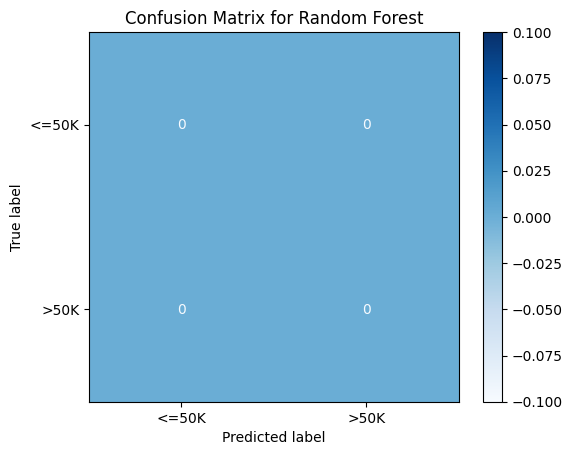

[Warning] Manual CV failed for Random Forest: 'RandomForestScratch' object has no attribute 'score'

Model Evaluation Results:
               Accuracy Precision Recall F1 Score  AUC  \
Random Forest      NaN         0      0        0  N/A   

              Cross-Validation Accuracy  
Random Forest                     Error  


In [26]:
# Convert labels to binary
y_train_bin = (y_train == y_train.max()).astype(int).values
y_test_bin = (y_test == y_test.max()).astype(int).values

for name, model in models.items():
    print(f"\nEvaluating: {name}")

    # Fit the model if possible
    if hasattr(model, "fit"):
        model.fit(X_train.values, y_train_bin)

    # Predict probabilities if supported
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)
        
        # If output is 2D, take class 1 probability
        if len(y_probs.shape) > 1 and y_probs.shape[1] == 2:
            y_probs = y_probs[:, 1]
        
        # Binary prediction using threshold
        y_pred = (y_probs > 0.5).astype(int)
    elif hasattr(model, "predict"):
        y_pred = model.predict(X_test.values)

        # Convert floats to binary if needed
        if isinstance(y_pred[0], (float, np.float32, np.float64)):
            y_pred = [1 if p > 0.5 else 0 for p in y_pred]
        y_probs = None  # No probabilities available
    else:
        print(f"Model {name} has no predict method.")
        continue

    # Evaluate custom metrics
    cm, TN, FP, FN, TP = confusion_matrix(y_test_bin, y_pred)
    acc = accuracyScratch(TP, TN, FP, FN)
    prec = precisionScratch(TP, FP)
    rec = recallScratch(TP, FN)
    f1 = f1_scoreScratch(TP, FP, FN)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    # Confusion matrix
    if 'plot_confusion_matrix' in globals():
        plot_confusion_matrix(y_test_bin, y_pred, name)

    # ROC curve
    if y_probs is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test_bin, y_probs)
            roc_auc = auc(fpr, tpr)
            results[name]['AUC'] = roc_auc

            plt.figure()
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc='lower right')
            plt.show()
        except Exception as e:
            print(f"[Warning] ROC curve failed for {name}: {e}")
            results[name]['AUC'] = "Error"
    else:
        results[name]['AUC'] = "N/A"

    # Cross-validation (manual or built-in)
    if hasattr(model, "score"):
        try:
            cv_scores = cross_val_score(model, X_train.values, y_train_bin, cv=5)
            results[name]['Cross-Validation Accuracy'] = np.mean(cv_scores)
        except Exception as e:
            print(f"[Warning] CV failed for {name}: {e}")
            results[name]['Cross-Validation Accuracy'] = "Error"
    elif 'cross_val_score_manual' in globals():
        try:
            cv_scores = cross_val_score_manual(model, X_train.values, y_train_bin, cv=5)
            results[name]['Cross-Validation Accuracy'] = np.mean(cv_scores)
        except Exception as e:
            print(f"[Warning] Manual CV failed for {name}: {e}")
            results[name]['Cross-Validation Accuracy'] = "Error"
    else:
        results[name]['Cross-Validation Accuracy'] = "N/A"

# Results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\nModel Evaluation Results:\n", results_df)

In [24]:
# Convert labels to binary
y_train_bin = (y_train == y_train.max()).astype(int).values
y_test_bin = (y_test == y_test.max()).astype(int).values

for name, model in models.items():
    print(f"\nEvaluating: {name}")

    # Fit the model if possible
    if hasattr(model, "fit"):
        model.fit(X_train.values, y_train_bin)

    # Predict probabilities if supported
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)
        
        # If output is 2D, take class 1 probability
        if len(y_probs.shape) > 1 and y_probs.shape[1] == 2:
            y_probs = y_probs[:, 1]
        
        # Binary prediction using threshold
        y_pred = (y_probs > 0.5).astype(int)
    elif hasattr(model, "predict"):
        y_pred = model.predict(X_test.values)

        # Convert floats to binary if needed
        if isinstance(y_pred[0], (float, np.float32, np.float64)):
            y_pred = [1 if p > 0.5 else 0 for p in y_pred]
        y_probs = None  # No probabilities available
    else:
        print(f"Model {name} has no predict method.")
        continue

    # Evaluate custom metrics
    cm, TN, FP, FN, TP = confusion_matrix(y_test_bin, y_pred)
    acc = accuracyScratch(TP, TN, FP, FN)
    prec = precisionScratch(TP, FP)
    rec = recallScratch(TP, FN)
    f1 = f1_scoreScratch(TP, FP, FN)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    # Confusion matrix
    if 'plot_confusion_matrix' in globals():
        plot_confusion_matrix(y_test_bin, y_pred, name)

    # ROC curve
    if y_probs is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test_bin, y_probs)
            roc_auc = auc(fpr, tpr)
            results[name]['AUC'] = roc_auc

            plt.figure()
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc='lower right')
            plt.show()
        except Exception as e:
            print(f"[Warning] ROC curve failed for {name}: {e}")
            results[name]['AUC'] = "Error"
    else:
        results[name]['AUC'] = "N/A"

    # Cross-validation (manual or built-in)
    if hasattr(model, "score"):
        try:
            cv_scores = cross_val_score(model, X_train.values, y_train_bin, cv=5)
            results[name]['Cross-Validation Accuracy'] = np.mean(cv_scores)
        except Exception as e:
            print(f"[Warning] CV failed for {name}: {e}")
            results[name]['Cross-Validation Accuracy'] = "Error"
    elif 'cross_val_score_manual' in globals():
        try:
            cv_scores = cross_val_score_manual(model, X_train.values, y_train_bin, cv=5)
            results[name]['Cross-Validation Accuracy'] = np.mean(cv_scores)
        except Exception as e:
            print(f"[Warning] Manual CV failed for {name}: {e}")
            results[name]['Cross-Validation Accuracy'] = "Error"
    else:
        results[name]['Cross-Validation Accuracy'] = "N/A"

# Results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\nModel Evaluation Results:\n", results_df)


Evaluating: SVM


ValueError: shapes (26029,14) and (6508,14) not aligned: 14 (dim 1) != 6508 (dim 0)


Evaluating: Logistic Regression


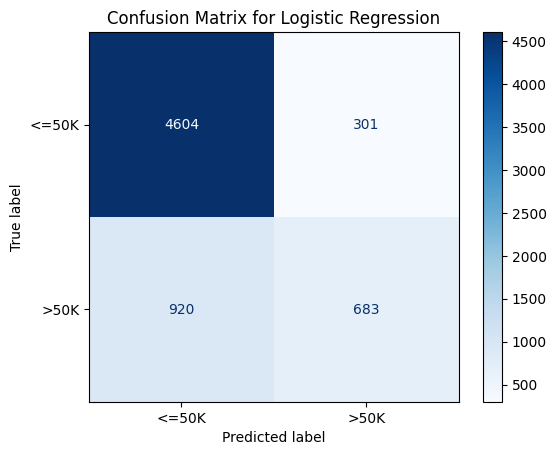

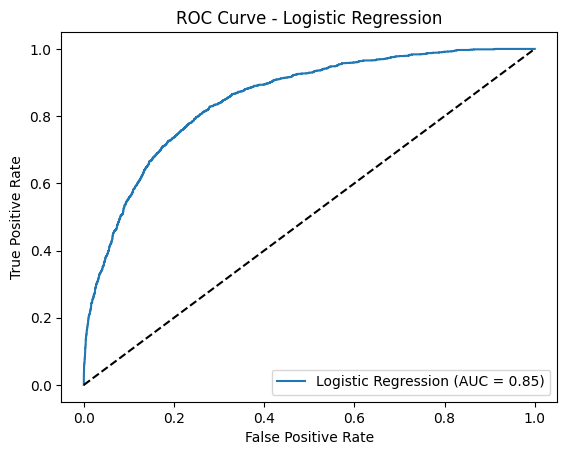

[Warning] CV failed for Logistic Regression: Cannot clone object '<__main__.LogisticRegressionScratch object at 0x000001F3B7BCE350>' (type <class '__main__.LogisticRegressionScratch'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Evaluating: Decision Tree


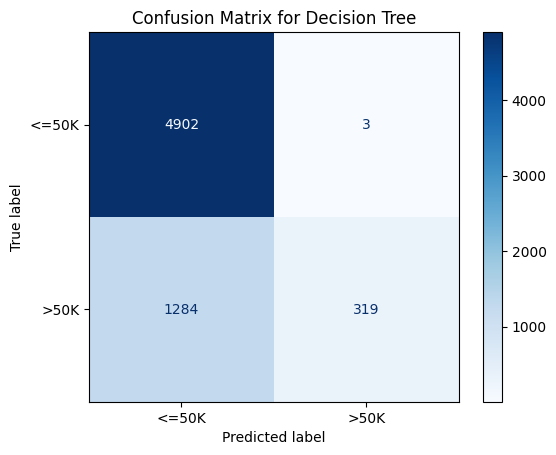

[Warning] Manual CV failed for Decision Tree: 'DecisionTreeScratch' object has no attribute 'score'

Evaluating: Random Forest


KeyboardInterrupt: 

In [19]:
# Convert labels to binary
y_train_bin = (y_train == y_train.max()).astype(int).values
y_test_bin = (y_test == y_test.max()).astype(int).values

for name, model in models.items():
    print(f"\nEvaluating: {name}")

    # Fit the model if possible
    if hasattr(model, "fit"):
        model.fit(X_train.values, y_train_bin)

    # Predict probabilities if supported
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test.values)
        
        # If output is 2D, take class 1 probability
        if len(y_probs.shape) > 1 and y_probs.shape[1] == 2:
            y_probs = y_probs[:, 1]
        
        # Binary prediction using threshold
        y_pred = (y_probs > 0.5).astype(int)
    elif hasattr(model, "predict"):
        y_pred = model.predict(X_test.values)

        # Convert floats to binary if needed
        if isinstance(y_pred[0], (float, np.float32, np.float64)):
            y_pred = [1 if p > 0.5 else 0 for p in y_pred]
        y_probs = None  # No probabilities available
    else:
        print(f"Model {name} has no predict method.")
        continue

    # Evaluate custom metrics
    cm, TN, FP, FN, TP = confusion_matrix(y_test_bin, y_pred)
    acc = accuracyScratch(TP, TN, FP, FN)
    prec = precisionScratch(TP, FP)
    rec = recallScratch(TP, FN)
    f1 = f1_scoreScratch(TP, FP, FN)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    # Confusion matrix
    if 'plot_confusion_matrix' in globals():
        plot_confusion_matrix(y_test_bin, y_pred, name)

    # ROC curve
    if y_probs is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test_bin, y_probs)
            roc_auc = auc(fpr, tpr)
            results[name]['AUC'] = roc_auc

            plt.figure()
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc='lower right')
            plt.show()
        except Exception as e:
            print(f"[Warning] ROC curve failed for {name}: {e}")
            results[name]['AUC'] = "Error"
    else:
        results[name]['AUC'] = "N/A"

    # Cross-validation (manual or built-in)
    if hasattr(model, "score"):
        try:
            cv_scores = cross_val_score(model, X_train.values, y_train_bin, cv=5)
            results[name]['Cross-Validation Accuracy'] = np.mean(cv_scores)
        except Exception as e:
            print(f"[Warning] CV failed for {name}: {e}")
            results[name]['Cross-Validation Accuracy'] = "Error"
    elif 'cross_val_score_manual' in globals():
        try:
            cv_scores = cross_val_score_manual(model, X_train.values, y_train_bin, cv=5)
            results[name]['Cross-Validation Accuracy'] = np.mean(cv_scores)
        except Exception as e:
            print(f"[Warning] Manual CV failed for {name}: {e}")
            results[name]['Cross-Validation Accuracy'] = "Error"
    else:
        results[name]['Cross-Validation Accuracy'] = "N/A"

# Results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\nModel Evaluation Results:\n", results_df)


In [ ]:
# 7. Modélisation sklearn
# Choix des modèles
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [None, 5, 10, 15]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    'SVM': {'C': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}
}
results = {}

In [ ]:
for model_name, model in models.items():
    grid = GridSearchCV(model, param_grid[model_name], cv=5, scoring='f1')
    grid.fit(X_train, y_train_bin)
    
    # Predict on the test set
    y_pred = grid.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_bin, y_pred)
    precision = precision_score(y_test_bin, y_pred)
    recall = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)

    if hasattr(model, "predict_proba"):
        y_probs = grid.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test_bin, y_probs)
        roc_auc = auc(fpr, tpr)
    else:
        roc_auc = "N/A"

    # Cross-validation
    if hasattr(model, "score"):
        cross_val = cross_val_score(model, X_train, y_train_bin, cv=5).mean()
    else:
        cross_val = "N/A"
    
    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': roc_auc,
        'Cross-Validation Accuracy': cross_val
    }

# display the results
skresults_df = pd.DataFrame(results).T
skresults_df = skresults_df.sort_values(by='F1 Score', ascending=False)
print("Model Evaluation Results with GridSearchCV:\n", skresults_df)

for model_name, model in models.items():
    grid = GridSearchCV(model, param_grid[model_name], cv=5, scoring='f1')
    grid.fit(X_train, y_train_bin)
    
    # Predict on the test set
    y_pred = grid.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_bin, y_pred)
    precision = precision_score(y_test_bin, y_pred)
    recall = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)

    if hasattr(model, "predict_proba"):
        y_probs = grid.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test_bin, y_probs)
        roc_auc = auc(fpr, tpr)
    else:
        roc_auc = "N/A"

    # Cross-validation
    if hasattr(model, "score"):
        cross_val = cross_val_score(model, X_train, y_train_bin, cv=5).mean()
    else:
        cross_val = "N/A"
    
    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': roc_auc,
        'Cross-Validation Accuracy': cross_val
    }

# display the results
skresults_df = pd.DataFrame(results).T
skresults_df = skresults_df.sort_values(by='F1 Score', ascending=False)
print("Model Evaluation Results with GridSearchCV:\n", skresults_df)


In [ ]:
# 1.5 Analyse des résultats et comparison entre les modèles sklearn et non-sklearn

common_cols = list(set(results_df.columns).intersection(set(skresults_df.columns)))
results_df = results_df[common_cols]
skresults_df = skresults_df[common_cols]

results_df["Model Type"] = "Scratch"
skresults_df["Model Type"] = "Sklearn"

combined_df = pd.concat([results_df, skresults_df], axis=0)
combined_df = combined_df.reset_index().rename(columns={"index": "Model Name"})

comparison_table = combined_df.pivot_table(
    index="Model Name",
    columns="Model Type",
    values=["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "Cross-Validation Accuracy"]
)

print("\n🔍 Side-by-side Comparison Table:\n")
print(comparison_table)

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
for metric in metrics:
    plt.figure(figsize=(10, 4))
    sns.barplot(data=combined_df, x="Model Name", y=metric, hue="Model Type")
    plt.title(f"{metric} Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


print("\nComparaison des performances:")
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-Score"])
print(results_df.T)

best_model = results_df.T["Accuracy"].idxmax()
print(f"\nMeilleur modèle selon Accuracy: {best_model}")

best_model = results_df.T["Precision"].idxmax()
print(f"\nMeilleur modèle selon Precision: {best_model}")

best_model = results_df.T["Recall"].idxmax()
print(f"\nMeilleur modèle selon Recall: {best_model}")

best_model = results_df.T["F1-Score"].idxmax()
print(f"\nMeilleur modèle selon F1-Score: {best_model}")


Comparaison des performances:
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.856792   0.748703  0.630069  0.684282
Decision Tree        0.815612   0.620586  0.646912  0.633476
Random Forest        0.858482   0.751475  0.635683  0.688746
SVM                  0.846189   0.741573  0.576419  0.648649

Meilleur modèle selon Accuracy: Random Forest

Meilleur modèle selon Precision: Random Forest

Meilleur modèle selon Recall: Decision Tree

Meilleur modèle selon F1-Score: Random Forest



Logistic Regression Evaluation:
Accuracy: 0.8567916410571604
Precision: 0.748702742772424
Recall: 0.6300686213349969
F1 Score: 0.6842818428184282


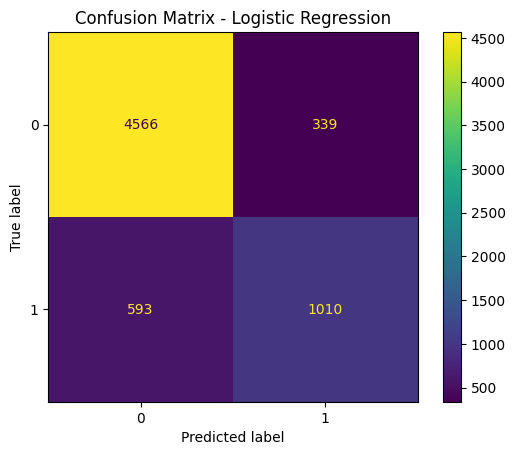


Decision Tree Evaluation:
Accuracy: 0.8156115550092194
Precision: 0.6205864751645721
Recall: 0.6469120399251403
F1 Score: 0.6334758704948076


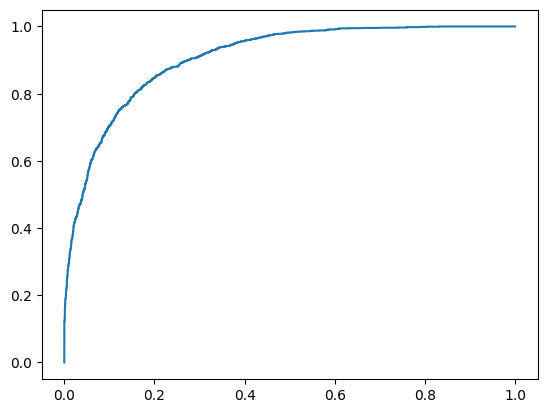

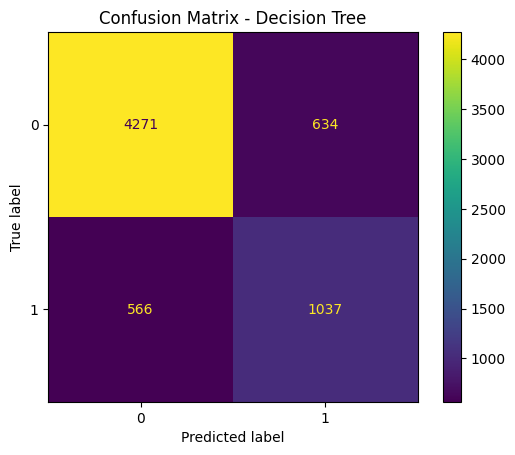


Random Forest Evaluation:
Accuracy: 0.8584818684695759
Precision: 0.7514749262536873
Recall: 0.6356830941983781
F1 Score: 0.6887461980398784


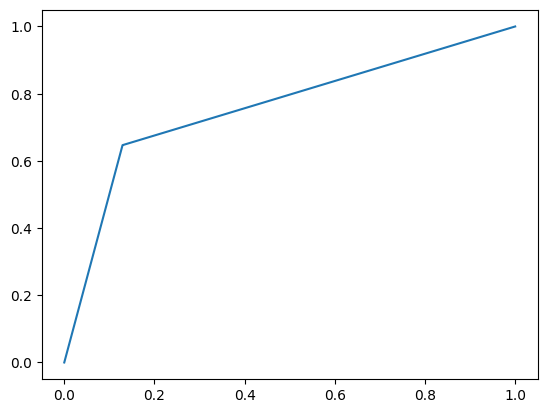

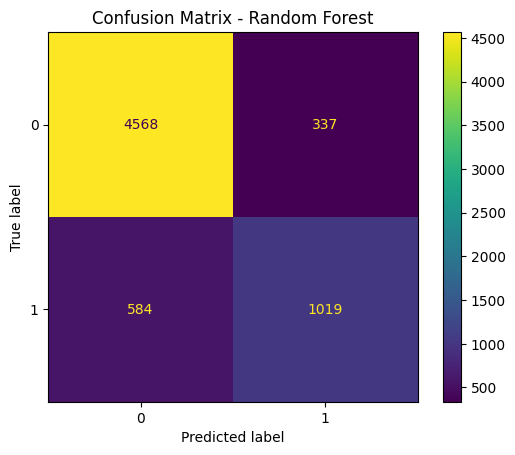


SVM Evaluation:
Accuracy: 0.8461893054701906
Precision: 0.7415730337078652
Recall: 0.5764192139737991
F1 Score: 0.6486486486486487


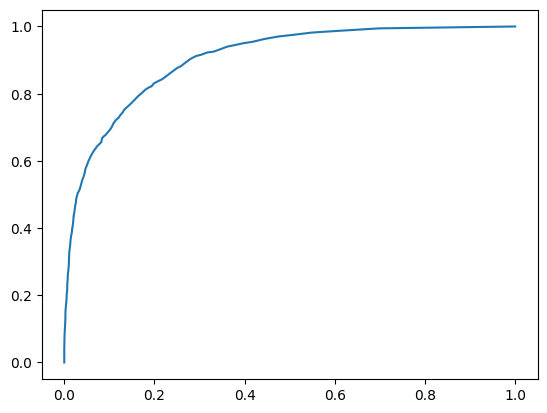

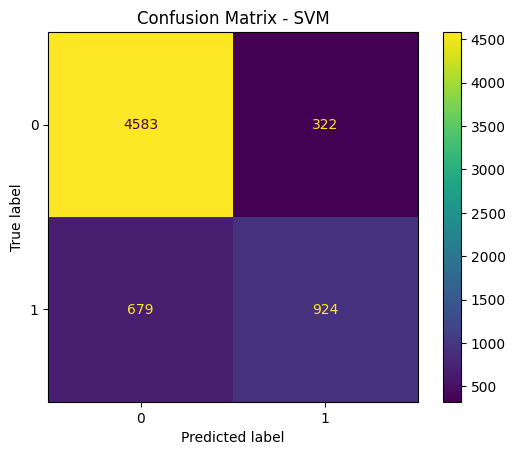

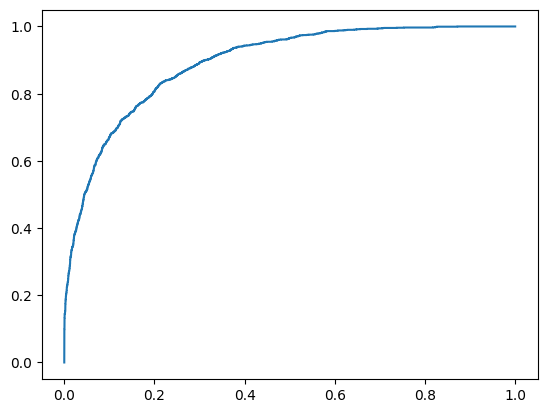

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = [acc, prec, rec, f1]
    print(f"\n{name} Evaluation:")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Courbe ROC
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')